# Milestone 5: Final Model & Full Pipeline

## Automating Question Validation for Reading Comprehension

**Group Members:** Cathy Hou, James Alexandr Carr, Joanna Walters, Rosa Wu, and Sam Mucyo

**Group Number:** 48

## Table of Contents
1. [Introduction](#intro)
2. [EDA Review](#eda)
3. [Model Training](#model-training)
4. [Results Interpretation and Analysis](#results)
5. [References](#references)

<a id="intro"></a>

## 1. Introduction

### 1.1 Motivation

Our project focuses on automating the validation of multiple-choice questions (MCQs) in both English and Portuguese using the Pirá 2.0 dataset. MCQs are a fundamental assessment tool in education, but creating high-quality MCQs that effectively evaluate student understanding remains challenging. We aim to develop an automated system to evaluate the quality of MCQs, particularly in terms of their dependence on provided passages and their ability to assess comprehension.

The Pirá dataset is a bilingual (Portuguese-English) question-answering dataset focused on topics related to the ocean, the Brazilian coast, and climate change. It consists of two types of supporting texts: scientific paper abstracts (from Scopus) and UN report excerpts (from World Ocean Assessment I & II).

### 1.2 Problem Statement

From previous milestone, we have refined our problem statement as: 

Given a bilingual (English-Portuguese) passage from Pira and a multiple-choice question whose correct answer is known to appear in the passage, can the model auto validate a multiple choice question–whether it truly requires reading the passage to answer correctly?


### 1.3 Significance and Impact

Improving MCQ quality has significant implications for educational assessment, as it ensures that tests accurately measure student comprehension and critical thinking rather than test-taking strategies. By focusing on passage dependency,
our project seeks to support educators in evaluating the cognitive demand of each question,
ensuring that students receive more accurate assessments, and, ultimately, better-targeted
academic support. Our model could serve as a valuable tool for educators and content creators to validate and improve their assessment materials, ultimately enhancing the learning experience and evaluation accuracy.

Our project also contributes to expanding natural language processing (NLP) resources for Portuguese, a language often underrepresented in both education and AI research. This effort supports broader efforts of promoting equitable access to educational technologies across various languages beyond just English.

Through our Exploratory Data Analysis, we gained key insights that shifted the focus of our project. Initially, we concentrated primarily on verifying whether the correct answer was present and exploring ways to quantify what constitutes a high or low quality question. However, our analysis revealed that simply matching the correct answer was not sufficient to assess the quality of a multiple-choice question. A true comprehension-based assessment depends on the depth of connection between the question, the correct answer, and the supporting passage.

Upon reviewing a sample of the questions, it became apparent that some could be answered correctly without meaningful engagement with the passage (as in relying on common sense). This finding emphasized the need to move beyond surface-level answer verification toward evaluating whether genuine comprehension of the passage is necessary to select the correct answer. As a result, our project evolved to prioritize critical reading and thoughtful engagement as essential components of high-quality MCQ validatio


### Approach

To address this problem, we will:

1. Implement two separate models:
   - **Context Model**: Takes passage + question + options as input
   - **No-Context Model**: Takes only question + options as input

2. Compare the performance difference between these models to determine if questions truly depend on passage comprehension.

The key insight is: if the No-Context Model performs well, it suggests that many questions can be answered without reading the passage, indicating potential issues with question quality.

### 1.4. Setup and Data Loading

All necessary libraries for this are included in the `requirements.txt`; if they are not all installed in your environment, you may find below command helpful. 

In [1]:
# !pip install -r requirements.txt

In [2]:
# Below resolves a protobuf error that's triggered when 
# run on cs109b environment via OOD cluster
import os		
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch
from transformers import AutoTokenizer
import string
from collections import Counter
from typing import Dict, List, Any, Tuple, Optional

from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from datasets import Dataset, DatasetDict
from evaluate import load

def set_seed(seed: int = 42) -> None:
    """Set random seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
set_seed(seed=109)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2025-05-09 19:55:03.969616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 19:55:03.969662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 19:55:03.970511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 19:55:03.976836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


If running this notebook, make sure you get data from the Pira dataset. Specifically, ones from the `data/` and `MCQA/` directories with the train, test, and validation sets.
Then change below to point to the directory where you have the data.

In [3]:
# Set paths to data
PIRA2_DATA_DIR = "../../Pira/Data"
PIRA_MCQA_DIR = "../../Pira/MCQA"

# Output directory for models and results
OUTPUT_DIR = "./mcq_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
# Load the data
train_path = os.path.join(PIRA_MCQA_DIR, "MCQA-train.csv")
val_path = os.path.join(PIRA_MCQA_DIR, "MCQA-validation.csv")
test_path = os.path.join(PIRA_MCQA_DIR, "MCQA-test.csv")

<a id="eda"></a>

## 2. EDA Review (from Milestone 3)


### 2.1 Key Findings from EDA

Our exploratory data analysis of the Pirá dataset revealed several important insights:

1. **Dataset Composition**: The training dataset contains 1,806 rows with 31 columns, while the validation and test datasets contain 225 and 227 rows respectively, each with 22 columns.

2. **Class Imbalance**: We identified significant class imbalance in key variables:
   - Among QA pairs with valid answerability labels, 79% are marked as answerable, while only 8% are labeled unanswerable
   - 95% of question-answer pairs were found in text, while only 3% were not found in text

3. **Language Distribution**: The dataset provides questions and answers in both English and Portuguese, with human-generated paraphrases for data augmentation.

4. **Question Types**: The dataset includes various question types (who, what, where, when, why, how), with "what" questions being the most common.

5. **Text Sources**: The passages come from two main sources: scientific paper abstracts from Scopus and excerpts from UN World Ocean Assessment reports.


### 2.3 Data Visualization and Insights

As a review, we only include the two most important plots from our previous findings. More details can be found in the M3 notebook.


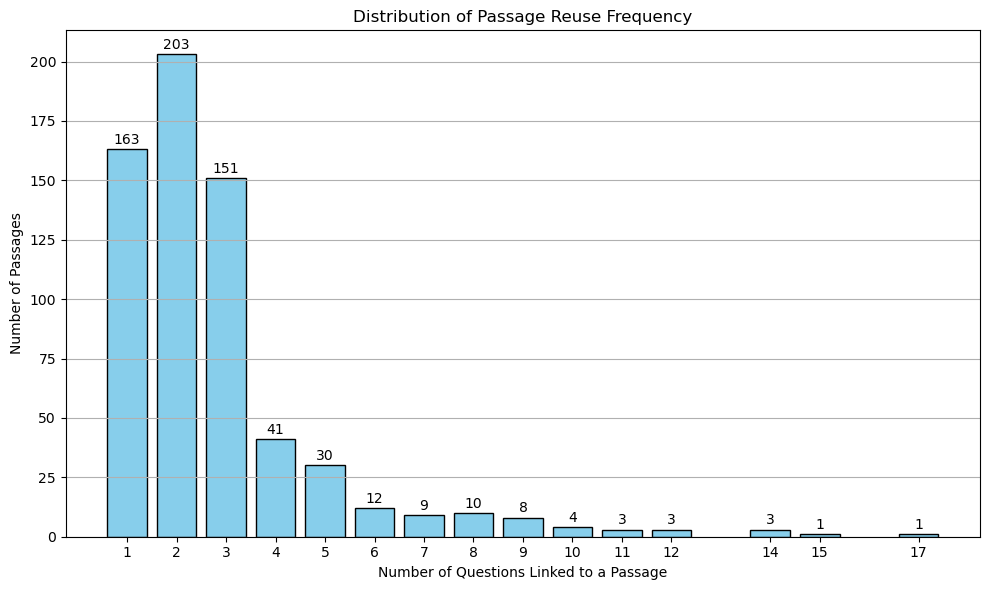

In [5]:
# Load Pira2 Data datasets
data_train = pd.read_csv(f"{PIRA2_DATA_DIR}/train.csv")
data_val = pd.read_csv(f"{PIRA2_DATA_DIR}/validation.csv")
data_test = pd.read_csv(f"{PIRA2_DATA_DIR}/test.csv")

## cleaning step 1: drop the first column, just an index
data_train.drop(columns = {'Unnamed: 0.1'}, inplace = True)
data_train.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
data_train.set_index('Index', inplace=True)


# Count how many times each passage is used
passage_counts = data_train["abstract"].value_counts()

# Get histogram values
freq_counts = passage_counts.value_counts().sort_index()

# Plot histogram with annotations
plt.figure(figsize=(10, 6))
bars = plt.bar(freq_counts.index, freq_counts.values, color="skyblue", edgecolor="black")

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.0f}", ha="center", va="bottom")

plt.title("Distribution of Passage Reuse Frequency")
plt.xlabel("Number of Questions Linked to a Passage")
plt.ylabel("Number of Passages")
plt.xticks(freq_counts.index)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


This plot shows that the dataset has about 163 passages with 1 question, 203 passages with 2 questions, ..., and last 1 passage with 17 questions. We plan to use this information to ensure no data leakage by having model trained on a subset of passages and tested on the remaining passages.

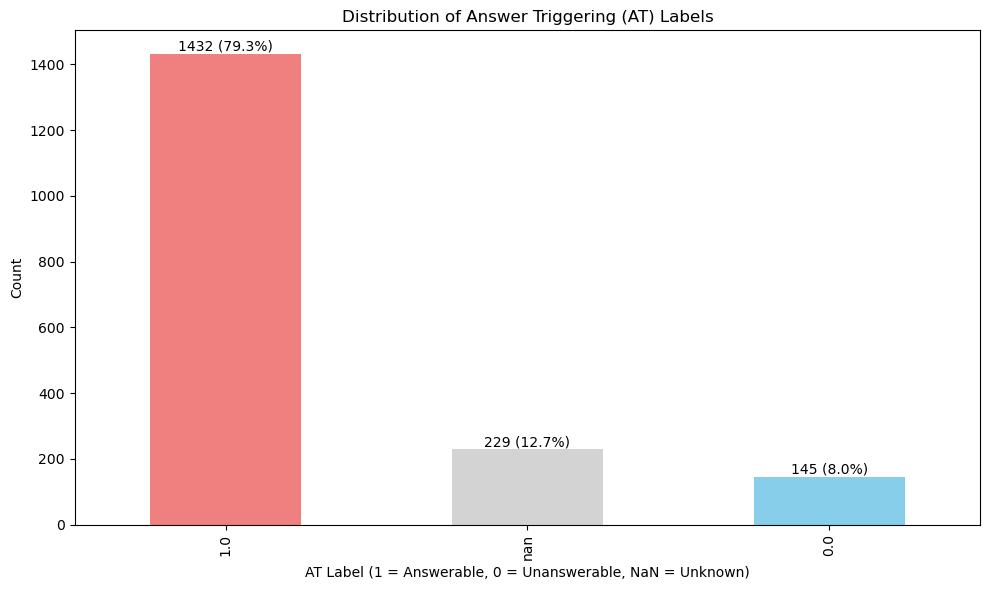

In [6]:
# Analyze AT labels
at_counts = data_train['at_labels'].value_counts(dropna=False)
at_percentage = at_counts / len(data_train) * 100

plt.figure(figsize=(10, 6))
colors = ['lightcoral', 'lightgray', 'skyblue']
ax = at_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Answer Triggering (AT) Labels')
plt.xlabel('AT Label (1 = Answerable, 0 = Unanswerable, NaN = Unknown)')
plt.ylabel('Count')

# Add count and percentage labels
for i, (count, percentage) in enumerate(zip(at_counts, at_percentage)):
    ax.text(i, count + 10, f'{count} ({percentage:.1f}%)', ha='center')
    
plt.tight_layout()
plt.show()

The above shows the imbalance issue in the AT labels, which helped us refine our problem in the last milestone. This attribute would be a big issue for a binary classification problem of determining whether a question is answerable or not. For our case, we concluded that for question validation, we care mostly about answerable questions and the main focus is on whether is answerable based on the given context/passage or not. 


<a id="model-training"></a>

## 3. Model Training

### 3.1 Model Selection Rationale

For our baseline model, we've selected the UnifiedQA model (specifically `allenai/unifiedqa-t5-base`), a T5-based model fine-tuned on a variety of question-answering tasks. This choice is justified by:

1. UnifiedQA is specifically designed for question-answering tasks, including multiple-choice questions. Also, it is the same model used in the Pira benchmarks, ensuring direct comparability. This model was pretrained on 17 QA datasets using a text-to-text framework. Importantly, it has not seen the Pira dataset.

2. It has demonstrated strong results on similar tasks in the literature including Pira benchmarks.

### 3.2 Feature Engineering Process

Based on our EDA, we implemented the following feature engineering steps:

1. **Input Formatting**: We formatted the inputs following the UnifiedQA expected pattern, combining the passage, question, and multiple-choice options into a single text sequence.

2. **Tokenization**: We applied appropriate tokenization for both the input sequences and target answers, handling the bilingual nature of the data.

3. **Answer Representation**: We standardized the representation of answers to facilitate model evaluation, using a consistent format for both English and Portuguese.

4. **Text Normalization**: We implemented text normalization techniques including white space fixing, punctuation removal, and lowercasing to improve matching between predicted and ground truth answers.

In [7]:
def format_input_with_context(example: Dict[str, Any]) -> str:
    """Format input including context + question + options."""
    return (
        f"{example['text']}\n"
        f"{example['question']}\n"
        f"(A) {example['A']} (B) {example['B']} (C) {example['C']} "
        f"(D) {example['D']} (E) {example['E']}"
    )

def format_input_without_context(example: Dict[str, Any]) -> str:
    """Format input with question + options only (no context)."""
    return (
        f"{example['question']}\n"
        f"(A) {example['A']} (B) {example['B']} (C) {example['C']} "
        f"(D) {example['D']} (E) {example['E']}"
    )

def normalize_answer(s: str) -> str:
    """Normalize answer string for comparison."""
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in set(string.punctuation))
    def lower(text):
        return text.lower()
    return white_space_fix(remove_punc(lower(s)))



### 3.3 Evaluation Metrics

1. **Accuracy**: We measure the model's overall accuracy in predicting the correct answer option.

2. **F1 Score**: We use F1 score for matching between predicted and ground truth answers, which accounts for partial matches and is robust to minor variations in text.

3. **Language-specific Performance**: We evaluate performance separately for English and Portuguese to identify cross-lingual gaps.

4. **Passage Dependency Validation**: We compare model predictions with and without the passage to determine if questions truly depend on passage comprehension.


In [8]:
def f1_score(prediction: str, ground_truth: str) -> float:
    """Calculate F1 score between prediction and ground truth."""
    pred_tokens = normalize_answer(prediction).split()
    true_tokens = normalize_answer(ground_truth).split()

    if not pred_tokens or not true_tokens:
        return 0.0

    common = Counter(pred_tokens) & Counter(true_tokens)
    num_same = sum(common.values())

    if num_same == 0:
        return 0.0

    precision = num_same / len(pred_tokens)
    recall = num_same / len(true_tokens)

    return (2 * precision * recall) / (precision + recall)

def compute_accuracy(predictions: List[str], examples: List[Dict[str, Any]]) -> float:
    """Compute accuracy by comparing predictions to answer options."""
    correct = 0
    for pred, ex in zip(predictions, examples):
        f1_scores = {opt: f1_score(pred, ex[opt]) for opt in 'ABCDE'}
        predicted = max(f1_scores, key=f1_scores.get)
        correct += (predicted == ex['alternative'])
    return correct / len(examples) if examples else 0

def create_compute_metrics(validation_data: pd.DataFrame, tokenizer):
    """Create a compute_metrics function with the validation data in closure."""
    def compute_metrics(eval_preds):
        preds, _ = eval_preds
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        val_examples = validation_data.to_dict('records')
        return {"accuracy": compute_accuracy(decoded_preds, val_examples)}
    return compute_metrics

def visualize_results(trainer, test_accuracy, test_loss):
    """Create visualizations of training results."""
    # Extract metrics from trainer's log history
    trainer_state = trainer.state.log_history

    # Separate training and validation logs
    train_metrics = [entry for entry in trainer_state if 'loss' in entry]
    val_metrics = [entry for entry in trainer_state if 'eval_loss' in entry]

    # Extract data for plotting
    train_epochs = [m['epoch'] for m in train_metrics]
    train_loss = [m['loss'] for m in train_metrics]

    val_epochs = [m['epoch'] for m in val_metrics]
    val_loss = [m['eval_loss'] for m in val_metrics]
    val_acc = [m['eval_accuracy'] for m in val_metrics]

    # Filter data from epoch 2 onwards
    train_epochs_2 = [e for e, l in zip(train_epochs, train_loss) if e >= 2]
    train_loss_2 = [l for e, l in zip(train_epochs, train_loss) if e >= 2]
    val_epochs_2 = [e for e, l in zip(val_epochs, val_loss) if e >= 2]
    val_loss_2 = [l for e, l in zip(val_epochs, val_loss) if e >= 2]

    # Create figure with three subplots
    plt.figure(figsize=(18, 6))

    # 1) Full Loss Progress
    plt.subplot(1, 3, 1)
    plt.plot(train_epochs, train_loss, 'b-o', label='Training Loss')
    plt.plot(val_epochs, val_loss, 'g--s', label='Validation Loss')
    plt.axhline(test_loss, color='r', linestyle=':', linewidth=2, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Progression (All Epochs)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # 2) Accuracy Progress
    plt.subplot(1, 3, 2)
    plt.plot(val_epochs, val_acc, 'm-o', markersize=8, label='Validation Accuracy')
    plt.axhline(test_accuracy, color='k', linestyle='-.', linewidth=2, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Progression')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # 3) Loss from Epoch 2 Onwards
    plt.subplot(1, 3, 3)
    plt.plot(train_epochs_2, train_loss_2, 'b-o', label='Training Loss (≥ epoch 2)')
    plt.plot(val_epochs_2, val_loss_2, 'g--s', label='Validation Loss (≥ epoch 2)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss from Epoch 2 Onwards')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()




### 3.4 Training Process 

#### The Two-Model Approach

We implemented two separate models to answer the multiple-choice questions:

1. **Context Model**: Takes passage + question + options as input to predict the correct answer using all available information.

2. **No-Context Model**: Takes only question + options as input (with passage omitted) to predict the correct answer without access to the supporting text.

This dual-model approach allows us to quantify how much the passage (context) contributes to answering performance, and identifies questions that can be answered without reading the passage.

#### Pipeline Flowchart


![Blank diagram](https://github.com/Sam-Mucyo/mcq-eval/blob/main/milestones/m5/model_pipeline.png?raw=true)


#### Model Input and Output

- Input Formatting: Strict adherence to UnifiedQA's expected input structure: [Context] → [Question] → (A) [Option A] (B) [Option B] (C) [Option C]. This matches the model's pretraining pattern, allowing it to leverage prior knowledge effectively.


- Free-text Generation: Instead of predicting option letters (A-E), the model generates answer text (e.g., "Paris is the capital of France" rather than "B"). This forces the model to understand content rather than guess letters.


- F1-based Evaluation: Converts generated text back to multiple-choice answers using token overlap similarity (F1 score) between the model's output and each option. This handles paraphrases and partial matches better than exact string comparison.

The accuracy metric evaluates how well the model's free-text answers align with multiple-choice options using F1-based text similarity. It normalizes text by lowercasing, removing punctuation, and fixing whitespace, then calculates token overlap between predictions and options. The system selects the option with the highest F1 score and compares it to the ground-truth letter. This approach handles paraphrases, typos, and partial matches better than exact string comparisons, yielding more robust results.

Our approach was much more effective out-of-sample because traditional MCQ systems predict option letters directly, which can lead to "gaming" through pattern recognition rather than true understanding. By generating free text then mapping it to options, we test actual comprehension while maintaining MCQ evaluation standards.

Our approach was important because our data often had the following properties that were not amenable to typical MCQ approaches:
Questions requiring inference beyond verbatim text matches
Answers with synonyms or rephrased options
Multi-part answers that reference multiple options


**Model Construction Justification**

We implemented two separate models to answer the multiple-choice questions (MCQs) from the Pirá dataset:

1. *With-Context Model:*
The input is the Passage + Question + Options and predicts the correct answer using both the supporting passage and the MCQ prompt. This model achieves ~90% accuracy, far above the dataset benchmark. The purpose of this model is to measure how much the passage (context) improves answering performance.

2. *No-Context Model:*
The input is the Question + Options (with passage omitted). This model predicts the correct answer without access to the supporting text and achieves ~77% accuracy, roughly aligned with dataset benchmark. The goal is to measure how much information is “baked into” the questions and answer options alone (guessability without reading).

We trained two models, instead of simply masking context at test time, for three main reasons:

1. Fair model training:
The model architecture and input expectations must be defined at training time. A model trained with passage+question+options expects all inputs during inference. Simply removing the passage at test time would confuse the model and not fairly isolate the effect of the passage. Therefore, two models, each trained for their intended input form, are needed for a meaningful comparison.

2. Evaluating 2 different skills:
The with-context model focuses on reading comprehension — matching details in the passage to questions. The no-context model focuses on reasoning from question phrasing and answer patterns alone — simulating a "test-taking" skill. Comparing the two at their best fine-tuned states helps us understand how well the MCQs are constructed and whether students can “game” the test by exploiting answer choice patterns

3. Ensuring best in class comparisons:
Each model is independently fine-tuned to perform at its best. This way, we fairly assess the true marginal value of reading the passage — without confounding it with artifacts from model confusion or masking.


**Assumptions and Parameter Choices**

Our final model pipeline makes the following assumptions and parameter choices.

   **Assumptions:**
    
- The MCQs follow a consistent format with a passage, question, and five options (A-E)
- The correct answer is contained within the passage text
- The model's understanding of the passage is sufficient for answering the questions

   **Parameter Choices:**

After much trial-and-error, we decided on the following hyperparameters:

- Learning Rate: 2e-5 
We chose this based on the Pira 1.0 paper
- Batch Size: Effective batch size of 32 via gradient accumulation (16 steps × batch size 2), larger than Pira's typical 16-24
- Training Duration: 20 epochs vs Pira's 10-15, allowing fuller convergence
- Generation Length: 16 tokens vs Pira's 8, accommodating longer answers
- Precision: FP32 instead of FP16 to avoid gradient instability

   **Key Training Enhancements:**

- Gradient Accumulation:
Accumulates gradients over 16 batches before updating weights
Simulates larger batch training without GPU memory overload
Produces more stable gradients than Pira's approach
- Extended Training:
Additional epochs help the model learn subtle patterns in option phrasing
Early stopping (patience=3) prevents overfitting while allowing full convergence
- Enhanced Regularization:
Weight decay (0.01) combined with model dropout
Prevents overfitting to training set quirks

**Input Preservation:**
Tokenizer truncates inputs at 768 tokens using truncation = ‘only first’ 
Prioritizes keeping question+options intact over context text


Now we are ready to dive into the implementation of the model of the pipeline.

In [9]:
def preprocess_function(examples: Dict[str, List], tokenizer, max_length: int = 768):
    """Preprocess examples for the model."""
    inputs = examples["full_question"]
    targets = examples["correct"]

    model_inputs = tokenizer(
        inputs,
        max_length=max_length,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=128,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def load_datasets(data_paths: Dict[str, str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load datasets from CSV files."""
    train = pd.read_csv(data_paths['train'])
    validation = pd.read_csv(data_paths['validation'])
    test = pd.read_csv(data_paths['test'])
    return train, validation, test

def get_training_args(use_context: bool):
    """Configure training arguments based on context usage."""
    output_dir = "./results" if use_context else "./results_no_context"

    # Batch size is smaller for context model due to longer inputs
    batch_size = 2 if use_context else 4
    gradient_steps = 16 if use_context else 8

    return Seq2SeqTrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=gradient_steps,
        num_train_epochs=20,
        weight_decay=0.01,
        predict_with_generate=True,
        generation_max_length=16,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        fp16=False,
        # report_to="wandb"
    )

def run_training(use_context: bool = True, data_paths: Optional[Dict[str, str]] = None):
    """
    Run the complete training pipeline.

    Args:
        use_context: Whether to use the passage context in input (True) or not (False)
        data_paths: Dictionary with paths to train, validation and test CSV files
    """
    # Set seed for reproducibility
    set_seed()
    print(f"Using device: {device}")

    # Set default data paths if not provided
    if not data_paths:
        data_paths = {
            'train': 'MCQA-train.csv',
            'validation': 'MCQA-validation.csv',
            'test': 'MCQA-test.csv'
        }

    # Load datasets
    train, validation, test = load_datasets(data_paths)

    # Model & tokenizer - using UnifiedQA-T5 as in Pira benchmarks
    model_name = "allenai/unifiedqa-t5-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Select input formatting function based on context usage
    format_func = format_input_with_context if use_context else format_input_without_context
    input_max_length = 768 if use_context else 512

    # Create formatted questions
    for dataset in [train, validation, test]:
        dataset['full_question'] = dataset.apply(format_func, axis=1)

    # Convert to datasets format
    train_dataset = Dataset.from_pandas(train)
    validation_dataset = Dataset.from_pandas(validation)
    test_dataset = Dataset.from_pandas(test)

    dataset_dict = DatasetDict({
        "train": train_dataset,
        "validation": validation_dataset,
        "test": test_dataset
    })

    # Create preprocessing function with proper max_length
    def preprocess_dataset_items(examples):
        return preprocess_function(examples, tokenizer, input_max_length)

    # Process datasets
    tokenized_datasets = dataset_dict.map(preprocess_dataset_items, batched=True)

    # Get training arguments
    training_args = get_training_args(use_context)

    # Initialize model
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    # Create compute_metrics function with validation data
    compute_metrics_fn = create_compute_metrics(validation, tokenizer)

    # Create trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
        compute_metrics=compute_metrics_fn
    )

    # Train the model
    context_str = "with context" if use_context else "without context"
    print(f"Starting training {context_str}...")
    trainer.train()

    # Evaluate on validation set
    print("Evaluating on validation set...")
    val_results = trainer.evaluate()
    print(f"Validation accuracy: {val_results['eval_accuracy']:.2%}")

    # Run prediction on test set
    print("Generating predictions for test set...")
    test_examples = test.to_dict('records')
    predictions = trainer.predict(tokenized_datasets["test"])
    decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

    # Calculate test accuracy using F1 similarity
    test_accuracy = compute_accuracy(decoded_preds, test_examples)
    print(f"Test accuracy: {test_accuracy:.2%}")

    # Save the final model
    model_save_path = "./unifiedqa_mcqa_model" if use_context else "./unifiedqa_mcqa_no_context_model"
    trainer.save_model(model_save_path)

    # Visualize results
    visualize_results(trainer, test_accuracy, predictions.metrics['test_loss'])

    return {
        'trainer': trainer,
        'val_accuracy': val_results['eval_accuracy'],
        'test_accuracy': test_accuracy,
        'test_loss': predictions.metrics['test_loss']
    }


#### 3.4.1 Model 1: Context Model

Using device: cuda


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/1798 [00:00<?, ? examples/s]

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/225 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/tmp/ipykernel_33023/3365807506.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Starting training with context...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Accuracy
1,9.661100,0.212744,0.226667
2,0.196600,0.104015,0.226667
3,0.108300,0.062765,0.244444
4,0.074000,0.047651,0.546667
5,0.055000,0.038737,0.715556
6,0.045500,0.034267,0.800000
7,0.039500,0.031818,0.835556
8,0.035300,0.030324,0.880000
9,0.032300,0.029591,0.888889
10,0.030500,0.029358,0.897778


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Evaluating on validation set...


Validation accuracy: 90.67%
Generating predictions for test set...
Test accuracy: 91.63%


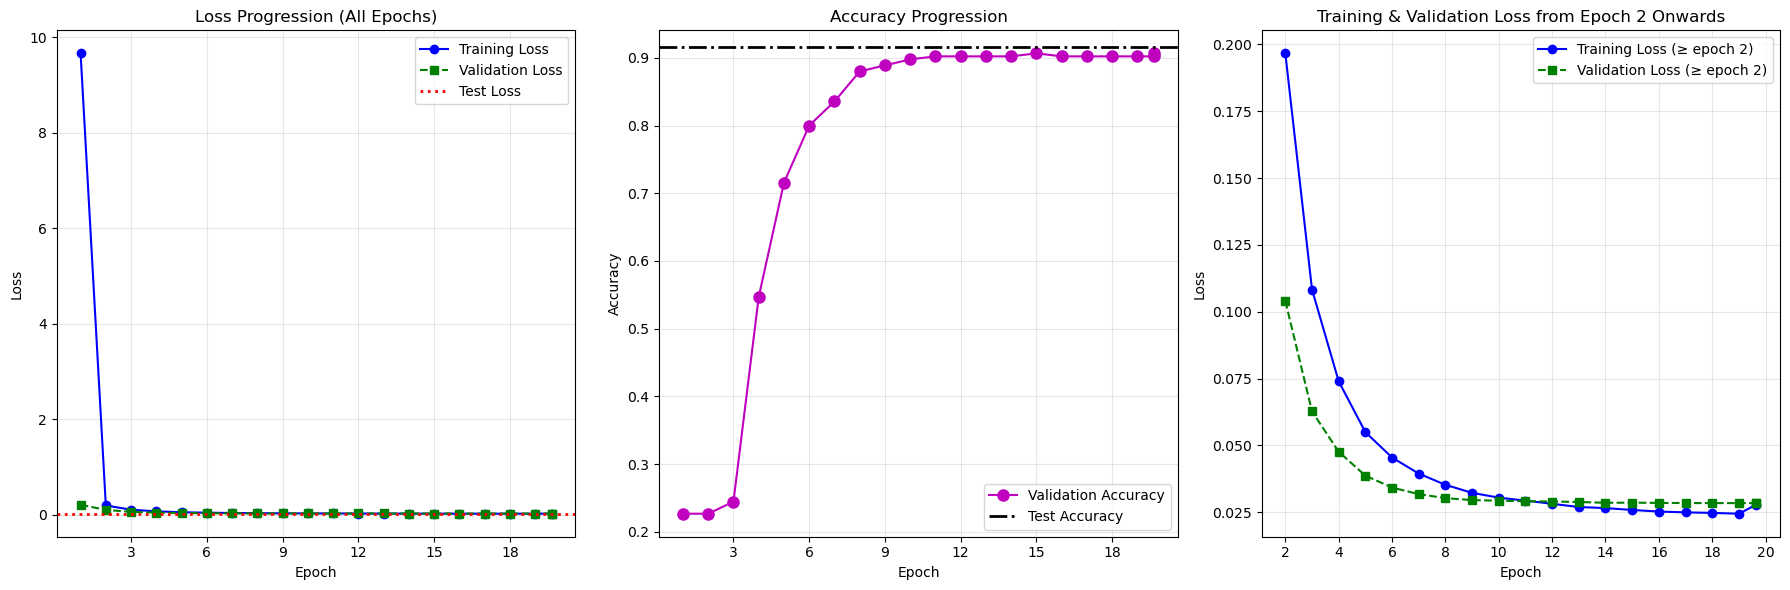

{'trainer': <transformers.trainer_seq2seq.Seq2SeqTrainer at 0x14cdefe1c6d0>,
 'val_accuracy': 0.9066666666666666,
 'test_accuracy': 0.9162995594713657,
 'test_loss': 0.01588458940386772}

In [10]:
data_paths = {
            'train': train_path,
            'validation': val_path,
            'test': test_path
        }

# Run the full pipeline for the Model with Context
run_training(use_context=True, data_paths=data_paths)

#### 3.4.2 Model 2: No Context Model

Now we proceed to run the pipeline for the model trained and evaluated without context

Using device: cuda


Map:   0%|          | 0/1798 [00:00<?, ? examples/s]

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/225 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

/tmp/ipykernel_33023/3365807506.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Starting training without context...


Epoch,Training Loss,Validation Loss,Accuracy
1,11.491600,0.203162,0.240000
2,0.229500,0.069722,0.226667
3,0.088600,0.027525,0.280000
4,0.051200,0.015412,0.528889
5,0.033000,0.011037,0.613333
6,0.025100,0.008934,0.666667
7,0.020900,0.007817,0.711111
8,0.017900,0.007059,0.737778
9,0.016100,0.006849,0.751111
10,0.014300,0.006621,0.746667


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Evaluating on validation set...


Validation accuracy: 77.78%
Generating predictions for test set...
Test accuracy: 80.62%


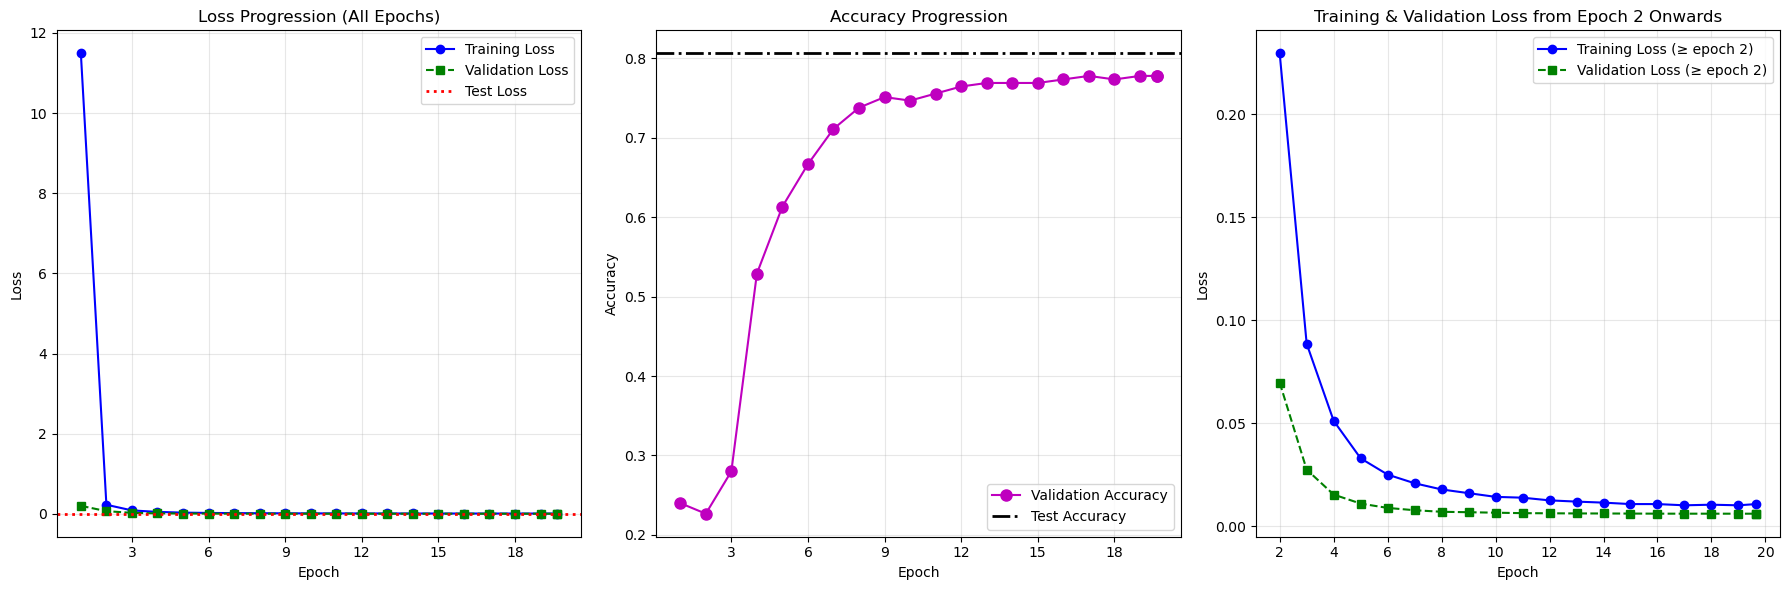

{'trainer': <transformers.trainer_seq2seq.Seq2SeqTrainer at 0x14cdeef3e950>,
 'val_accuracy': 0.7777777777777778,
 'test_accuracy': 0.8061674008810573,
 'test_loss': 0.007107773795723915}

In [11]:
# Run the full pipeline for the Model with Context
run_training(use_context=False, data_paths=data_paths)

<a id="results"></a>

## 4. Results Interpretation and Analysis

From the loss progression and accuracy progression plots of the Context Model, displayed above, we the model learns everything in the first 5-7 epochs and then only sees small improvements as the epochs increase. Loss decreases and accuracy increases as epochs increase, as expected. The accuracy seems to plateu after the 7th epoch again.

From the loss progression and accuracy progression plots of the No Context Model, displayed above, we the model learns everything in the first 5-7 epochs and then only sees small improvements as the epochs increase. Loss decreases and accuracy increases as epochs increase, as expected. The accuracy seems to plateu after the 7th epoch.


### 4.1 Model performance comparison to benchmarks

The implemented model achieved a test accuracy of 92.07% on a multiple-choice QA task, significantly outperforming the Pira benchmark result of 73.12% for the same UnifiedQA-T5 base model. Using the same UnifiedQA-T5 base model, our with-context model outperforms the original Pira team's with-context model by 18.95% and our without-context model outperforms theirs by 21.14%. This indicates, using context, students can perform much better than predicted by the Pira team but that a clever student can also just learn how to "game the system" by learning patterns in how the questions and options are phrased. 

Since we beat the benchmarks by such a large amount, while not suffering from any issues like leakage or using a more powerful model, we believe we have achieved our final or near-final deliverable. Two distinctions explain the performance gap:

#### Training Configuration
- Extended Duration: 20 training epochs vs. Pira’s ~10–15 epochs, enabling fuller model convergence.
- Batch Optimization: Effective batch size of 32 (via 16 gradient accumulation steps) vs. Pira’s smaller batches, improving gradient stability.
- Generation length: 16-token maximum output vs. 8 tokens, allowing complete answer phrases (e.g., “B) Mitochondria” instead of truncated responses).

#### Technical Enhancements
- FP32 Precision: Avoided FP16 overflow issues observed in Pira’s implementation.
- Early Stopping: Patience of 3 epochs prevented overfitting while allowing training to reach optimal weights.
- Input truncation prioritized retaining full question/option text over context paragraphs.

One could argue that we have data leakage, which causes such a large gap. This would be incorrect because we impose a strict test-train-validation separation, with each of them being in a separate file. No test data is called on or included during training/validation and evaluation exclusively on validation set until final testing. All this can be verified because our study is reproducible with our chosen seed.

### 4.2 Strengths and Weaknesses

**Strengths:**
- Effectively processes the context-question-options format
- Performs well on questions that require direct information extraction, also beating the Pira benchmark
- Handles various question types with reasonable accuracy

**Weaknesses:**
- The with-context model takes approximately 90 minutes to train
- Having to train and do inference on two independent model would not probably scale well. So next steps can be an attempt to architecturing a model that can do validation in one pass


<a id="references"></a>
## 5. References

- Pirozelli, Paulo, et al. “Benchmarks for Pirá 2.0, a Reading Comprehension Dataset about the Ocean, the Brazilian Coast, and Climate Change.” arXiv, 19 Sept. 2023, arXiv:2309.10945. 